In [19]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# 读取原始数据
print("正在读取ppm32.csv文件...")
df = pd.read_csv('../csv/ppm32.csv')
print(f"数据长度: {len(df)} 个采样点")

# 提取时间和数据
time = df['time'].values
data = df['data'].values

# 计算采样率
dt = time[1] - time[0]  # 采样间隔
fs = 1 / dt  # 采样率
print(f"采样间隔: {dt:.2e} 秒")
print(f"采样率: {fs:.2e} Hz")

# 显示数据基本统计信息
print(f"信号长度: {len(data)} 个采样点")
print(f"信号时间范围: {time[0]:.6f} - {time[-1]:.6f} 秒")
print(f"信号幅度范围: {np.min(data):.6f} - {np.max(data):.6f}")
print(f"信号RMS: {np.sqrt(np.mean(data**2)):.6f}")


正在读取ppm32.csv文件...
数据长度: 159961 个采样点
采样间隔: 3.13e-11 秒
采样率: 3.20e+10 Hz
信号长度: 159961 个采样点
信号时间范围: 0.000000 - 0.000005 秒
信号幅度范围: -0.161168 - 0.189508
信号RMS: 0.069553


In [20]:
# 设计FFT频域滤波参数
center_freq = 4e9  # 4 GHz 中心频率
bandwidth = 0.5e9  # 带宽设为0.5 GHz

print(f"FFT频域滤波参数:")
print(f"中心频率: {center_freq/1e9:.1f} GHz")
print(f"带宽: {bandwidth/1e6:.0f} MHz")

# 检查奈奎斯特频率
nyquist = fs / 2
print(f"奈奎斯特频率: {nyquist/1e9:.1f} GHz")

# 设置频率范围 (将在cell 3中使用)
lowcut_target = 3.75e9   # 3.75 GHz
highcut_target = 4.25e9  # 4.25 GHz

print(f"目标频率范围: {lowcut_target/1e9:.2f} - {highcut_target/1e9:.2f} GHz")

if highcut_target > nyquist:
    print("警告: 目标高频率超过奈奎斯特频率！")
    print(f"建议调整频率范围或增加采样率")
else:
    print("✓ 频率范围在有效范围内")


FFT频域滤波参数:
中心频率: 4.0 GHz
带宽: 500 MHz
奈奎斯特频率: 16.0 GHz
目标频率范围: 3.75 - 4.25 GHz
✓ 频率范围在有效范围内


In [25]:
# 使用FFT方法生成频域滤波噪声
noise_length = 8192  # 噪声段长度
np.random.seed(42)  # 设置随机种子以保证结果可重复

# 生成基础白噪声段 (长度8192)
noise_amplitude = np.std(data) * 0.5  # 噪声幅度设为信号标准差的10%
base_white_noise = np.random.normal(0, noise_amplitude, noise_length)

print(f"FFT频域滤波方法:")
print(f"基础噪声段长度: {noise_length}")
print(f"噪声幅度(标准差): {noise_amplitude:.6f}")
print(f"基础白噪声RMS: {np.sqrt(np.mean(base_white_noise**2)):.6f}")

# 对基础噪声段进行FFT
noise_fft = np.fft.fft(base_white_noise)
freqs_noise = np.fft.fftfreq(noise_length, dt)

# 创建频域滤波掩码 (保留3.75-4.25GHz频段)
lowcut = 3.75e9   # 3.75 GHz
highcut = 4.25e9  # 4.25 GHz

# 创建频域掩码
freq_mask = np.zeros(noise_length, dtype=bool)
# 对于正频率
pos_freq_mask = (freqs_noise >= lowcut) & (freqs_noise <= highcut)
# 对于负频率 (由于FFT的对称性)
neg_freq_mask = (freqs_noise >= -highcut) & (freqs_noise <= -lowcut)
freq_mask = pos_freq_mask | neg_freq_mask

print(f"\\n频域滤波参数:")
print(f"目标频率范围: {lowcut/1e9:.2f} - {highcut/1e9:.2f} GHz")
print(f"保留的频率点数: {np.sum(freq_mask)} / {noise_length}")

# 应用频域滤波
filtered_noise_fft = noise_fft.copy()
filtered_noise_fft[~freq_mask] = 0  # 将非目标频段置零

# 执行IFFT得到滤波后的时域噪声
base_filtered_noise = np.real(np.fft.ifft(filtered_noise_fft))

print(f"滤波后基础噪声段RMS: {np.sqrt(np.mean(base_filtered_noise**2)):.6f}")

# 重复噪声段以匹配原始信号长度
signal_length = len(data)
num_repeats = int(np.ceil(signal_length / noise_length))
repeated_noise = np.tile(base_filtered_noise, num_repeats)
# 截断到与原始信号相同长度
filtered_noise = repeated_noise[:signal_length]

print(f"\\n噪声重复信息:")
print(f"原始信号长度: {signal_length}")
print(f"重复次数: {num_repeats}")
print(f"最终噪声长度: {len(filtered_noise)}")
print(f"最终滤波噪声RMS: {np.sqrt(np.mean(filtered_noise**2)):.6f}")

# 将滤波后的噪声添加到原始信号
noisy_data = data + filtered_noise

print(f"\\n信号统计对比:")
print(f"原始信号RMS: {np.sqrt(np.mean(data**2)):.6f}")
print(f"滤波噪声RMS: {np.sqrt(np.mean(filtered_noise**2)):.6f}")
print(f"含噪信号RMS: {np.sqrt(np.mean(noisy_data**2)):.6f}")
print(f"信噪比(SNR): {20*np.log10(np.sqrt(np.mean(data**2))/np.sqrt(np.mean(filtered_noise**2))):.2f} dB")


FFT频域滤波方法:
基础噪声段长度: 8192
噪声幅度(标准差): 0.034676
基础白噪声RMS: 0.034951
\n频域滤波参数:
目标频率范围: 3.75 - 4.25 GHz
保留的频率点数: 256 / 8192
滤波后基础噪声段RMS: 0.006455
\n噪声重复信息:
原始信号长度: 159961
重复次数: 20
最终噪声长度: 159961
最终滤波噪声RMS: 0.006444
\n信号统计对比:
原始信号RMS: 0.069553
滤波噪声RMS: 0.006444
含噪信号RMS: 0.069851
信噪比(SNR): 20.66 dB


In [26]:
# 创建结果数据框并保存
result_df = pd.DataFrame({
    'time': time,
    'data': noisy_data
})

# 保存到新的CSV文件
output_filename = '../csv/phase_noise32.csv'
result_df.to_csv(output_filename, index=False)
print(f"\\n含噪声信号已保存到: {output_filename}")
print(f"保存的数据点数: {len(result_df)}")

# 验证保存的文件
saved_df = pd.read_csv(output_filename)
print(f"验证: 读取保存文件的数据点数: {len(saved_df)}")
print(f"时间范围: {saved_df['time'].min():.6f} - {saved_df['time'].max():.6f} 秒")
print(f"数据范围: {saved_df['data'].min():.6f} - {saved_df['data'].max():.6f}")

print("\\n处理完成！")


\n含噪声信号已保存到: ../csv/phase_noise32.csv
保存的数据点数: 159961
验证: 读取保存文件的数据点数: 159961
时间范围: 0.000000 - 0.000005 秒
数据范围: -0.177870 - 0.207756
\n处理完成！


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

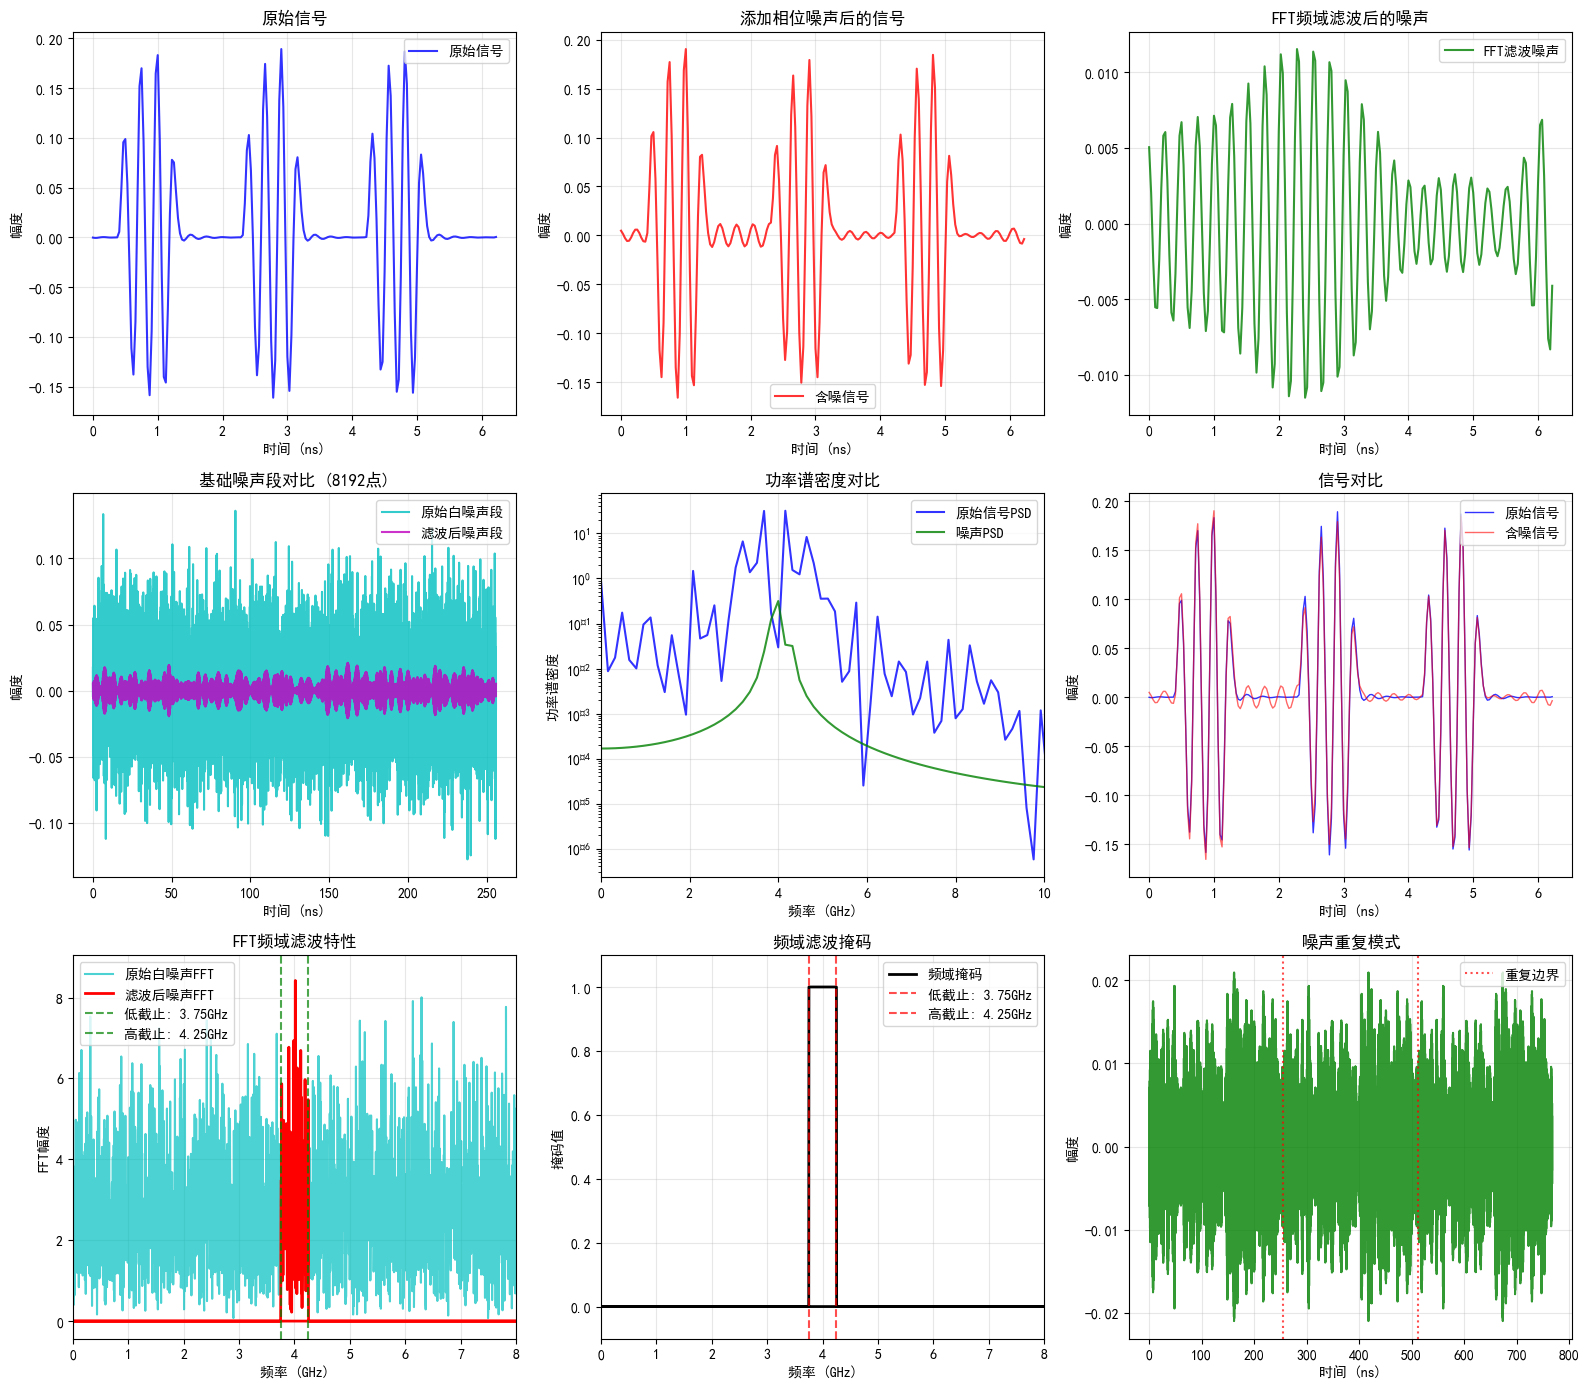

\n可视化完成，显示了前 200 个数据点
FFT频域滤波方法成功应用，基础噪声段长度: 8192


In [27]:
# 可视化结果
plt.figure(figsize=(16, 14))

# 选择显示的数据点数（避免绘图过慢）
n_display = min(200, len(time))
time_display = time[:n_display]
data_display = data[:n_display]
noisy_data_display = noisy_data[:n_display]
filtered_noise_display = filtered_noise[:n_display]

# 时域信号对比
plt.subplot(3, 3, 1)
plt.plot(time_display * 1e9, data_display, 'b-', label='原始信号', alpha=0.8)
plt.xlabel('时间 (ns)')
plt.ylabel('幅度')
plt.title('原始信号')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(3, 3, 2)
plt.plot(time_display * 1e9, noisy_data_display, 'r-', label='含噪信号', alpha=0.8)
plt.xlabel('时间 (ns)')
plt.ylabel('幅度')
plt.title('添加相位噪声后的信号')
plt.grid(True, alpha=0.3)
plt.legend()

# 噪声时域图
plt.subplot(3, 3, 3)
plt.plot(time_display * 1e9, filtered_noise_display, 'g-', label='FFT滤波噪声', alpha=0.8)
plt.xlabel('时间 (ns)')
plt.ylabel('幅度')
plt.title('FFT频域滤波后的噪声')
plt.grid(True, alpha=0.3)
plt.legend()

# 基础噪声段分析
plt.subplot(3, 3, 4)
time_base = np.arange(noise_length) * dt * 1e9  # 转换为ns
plt.plot(time_base, base_white_noise, 'c-', label='原始白噪声段', alpha=0.8)
plt.plot(time_base, base_filtered_noise, 'm-', label='滤波后噪声段', alpha=0.8)
plt.xlabel('时间 (ns)')
plt.ylabel('幅度')
plt.title('基础噪声段对比 (8192点)')
plt.grid(True, alpha=0.3)
plt.legend()

# 频域分析 - 原始信号vs噪声
plt.subplot(3, 3, 5)
freqs = np.fft.fftfreq(n_display, dt)
freqs_ghz = freqs / 1e9
# 计算功率谱密度
psd_original = np.abs(np.fft.fft(data_display))**2
psd_noise = np.abs(np.fft.fft(filtered_noise_display))**2

# 只显示正频率部分
positive_freq_idx = freqs >= 0
plt.semilogy(freqs_ghz[positive_freq_idx], psd_original[positive_freq_idx], 'b-', label='原始信号PSD', alpha=0.8)
plt.semilogy(freqs_ghz[positive_freq_idx], psd_noise[positive_freq_idx], 'g-', label='噪声PSD', alpha=0.8)
plt.xlabel('频率 (GHz)')
plt.ylabel('功率谱密度')
plt.title('功率谱密度对比')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, min(10, freqs_ghz.max()))  # 限制显示范围到10GHz

# 信号叠加对比
plt.subplot(3, 3, 6)
plt.plot(time_display * 1e9, data_display, 'b-', label='原始信号', alpha=0.8, linewidth=1)
plt.plot(time_display * 1e9, noisy_data_display, 'r-', label='含噪信号', alpha=0.6, linewidth=1)
plt.xlabel('时间 (ns)')
plt.ylabel('幅度')
plt.title('信号对比')
plt.grid(True, alpha=0.3)
plt.legend()

# FFT频域滤波特性
plt.subplot(3, 3, 7)
# 显示基础噪声段的FFT频谱
freqs_base_ghz = freqs_noise / 1e9
plt.plot(freqs_base_ghz, np.abs(noise_fft), 'c-', label='原始白噪声FFT', alpha=0.7)
plt.plot(freqs_base_ghz, np.abs(filtered_noise_fft), 'r-', label='滤波后噪声FFT', linewidth=2)
plt.axvline(lowcut/1e9, color='g', linestyle='--', alpha=0.7, label=f'低截止: {lowcut/1e9:.2f}GHz')
plt.axvline(highcut/1e9, color='g', linestyle='--', alpha=0.7, label=f'高截止: {highcut/1e9:.2f}GHz')
plt.xlabel('频率 (GHz)')
plt.ylabel('FFT幅度')
plt.title('FFT频域滤波特性')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, min(8, freqs_base_ghz.max()))

# 频域掩码可视化
plt.subplot(3, 3, 8)
plt.plot(freqs_base_ghz, freq_mask.astype(int), 'k-', linewidth=2, label='频域掩码')
plt.axvline(lowcut/1e9, color='r', linestyle='--', alpha=0.7, label=f'低截止: {lowcut/1e9:.2f}GHz')
plt.axvline(highcut/1e9, color='r', linestyle='--', alpha=0.7, label=f'高截止: {highcut/1e9:.2f}GHz')
plt.xlabel('频率 (GHz)')
plt.ylabel('掩码值')
plt.title('频域滤波掩码')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, min(8, freqs_base_ghz.max()))
plt.ylim(-0.1, 1.1)

# 噪声重复模式
plt.subplot(3, 3, 9)
# 显示噪声重复的开始部分
repeat_display_length = min(3 * noise_length, len(filtered_noise))
time_repeat = time[:repeat_display_length] * 1e9
noise_repeat = filtered_noise[:repeat_display_length]
plt.plot(time_repeat, noise_repeat, 'g-', alpha=0.8)
# 添加垂直线显示重复边界
for i in range(1, min(4, num_repeats)):
    boundary_time = i * noise_length * dt * 1e9
    if boundary_time < time_repeat[-1]:
        plt.axvline(boundary_time, color='r', linestyle=':', alpha=0.7, label='重复边界' if i == 1 else '')
plt.xlabel('时间 (ns)')
plt.ylabel('幅度')
plt.title('噪声重复模式')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"\\n可视化完成，显示了前 {n_display} 个数据点")
print(f"FFT频域滤波方法成功应用，基础噪声段长度: {noise_length}")
